In [74]:
using Arpack
using LinearAlgebra
using LaTeXStrings
using Revise
using PyPlot
using MeshGrid
using JLD2
using Statistics
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/Lattice_setup/lattice_BZ.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/patch_methods.jl")
includet("/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/3P_funcs/lambda_funcs.jl")
PyPlot.matplotlib.rcParams["ghostscript"] = "gs"
ENV["PATH"] = "/Library/TeX/texbin:" * ENV["PATH"]

"/Library/TeX/texbin:/Library/TeX/texbin:/Library/TeX/texbin:/opt/anaconda3/bin:/opt/anaconda3/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/Apple/usr/bin:/Library/TeX/texbin"

In [2]:
rc("text", usetex=true)
rc("font", family="serif", size=14)

# Spinorless Berry curvature

In [6]:
function approx_sign(x; tol=1e-13)
    if x > tol
        return 1
    elseif x < -tol
        return -1
    else
        return 0
    end
end
function explicit_og_bc_vF(delta, alpha, index, vF)
    omega = exp(im * 2 * pi/ 3)
    k = index - 1
    v = vF
    
    nmz = 16 * real(omega^k * delta)^4 + 3 * abs(delta)^4 + 8 * real(delta^3) * real(omega^k * delta)
    
    return ((8 * sqrt(3) / nmz^2) * (8 * v * real(omega^k * delta)^3 - 12 * real(alpha * conj(delta)) * real(omega^k * delta)^2 + 
    3 * abs2(delta) * real(alpha * conj(delta)) + v * real(delta^3)) * (4 * real(omega^k * delta)^2 * imag(alpha * conj(delta)) + 
    4 * real(omega^k * delta) * imag(alpha * delta^2) - v * imag(delta^3) + abs2(delta) * imag(alpha * conj(delta))))
    
end
function wrap_angle(ang)
    return mod(ang + pi, 2pi) - pi
end
function branch1_theta(vF, a, phi, k)
    # return wrap_angle((phi + acos(vF/a * (cos(3*phi) + 2 * cos(phi + 2*pi*k/3)) / (1 + 2 * cos(2*phi + 4 * pi * k / 3)))))
    return wrap_angle(phi + acos(vF/a * cos(phi + 2 * pi * k/3 )))
end
function branch2_roots(vF, a, varphi, k, n)
    theta = wrap_angle(varphi - 2*pi/3 * k)
    phi = wrap_angle(n*pi + atan(3 * sin(varphi) / (vF/a - cos(varphi))) + pi/3 * k)
    return [phi, theta]
end

branch2_roots (generic function with 1 method)

In [111]:
function plot_phase_boundary(vF, a)
    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_xlabel(L"$\arg(\Delta)$", fontsize = 16)
    axs.set_ylabel(L"$\arg(\alpha)$", fontsize = 16)

    ticks = [-1, -2/3, -1/3, 0, 1/3, 2/3, 1]
    labels = [L"$-\pi$", L"$-2 \pi / 3$", L"$- \pi / 3$", L"$0$", L"$ \pi / 3$", L"$2 \pi / 3$", L"$\pi$"]
    axs.set_xticks(ticks, labels=labels)
    axs.set_yticks(ticks, labels=labels)

    omega = exp(im * 2 * pi / 3)

    n_pts = 10^4
    varphi_list = range(-0.999*pi, 0.999*pi, n_pts)
    
    # root_sets = Array{Float64}(undef, 6, 2, n_pts)
    branch_2_roots_1_phi = []
    branch_2_roots_1_theta = []

    branch_2_roots_2_phi = []
    branch_2_roots_2_theta = []

    branch_2_roots_3_phi = []
    branch_2_roots_3_theta = []

    branch_1_roots = Array{Float64}(undef, 3, 2, n_pts)
    for j in 1:n_pts
        varphi = varphi_list[j]

        phim1 = wrap_angle(varphi - pi)
        phi0 = wrap_angle(varphi)
        phip1 = wrap_angle(varphi + pi)

        # Branch 1 roots first
        if 0 < phim1 && phim1 <= 2*pi/3
            km1 = 1
        elseif 2*pi/3 < phim1 || phim1 <= -2*pi/3
            km1 = 0
        elseif phim1 > -2*pi/3 && phim1 <= 0
            km1 = 2
        end

        if 0 < phi0 && phi0 <= 2*pi/3
            k0 = 1
        elseif 2*pi/3 < phi0 || phi0 <= -2*pi/3
            k0 = 0
        elseif phi0 > -2*pi/3 && phi0 <= 0
            k0 = 2
        end

        if 0 < phip1 && phip1 <= 2*pi/3
            kp1 = 1
        elseif 2*pi/3 < phip1 || phip1 <= -2*pi/3
            kp1 = 0
        elseif phip1 > -2*pi/3 && phip1 <= 0
            kp1 = 2
        end

        try
            branch_1_roots[1, 1, j] = phim1
            branch_1_roots[1, 2, j] = branch1_theta(vF, a, varphi_list[j], km1)
        catch e
            branch_1_roots[1, 1, j] = NaN
            branch_1_roots[1, 2, j] = NaN
        end
        try
            branch_1_roots[2, 1, j] = phi0
            branch_1_roots[2, 2, j] = branch1_theta(vF, a, varphi_list[j], k0)
        catch e
            branch_1_roots[2, 1, j] = NaN
            branch_1_roots[2, 2, j] = NaN
        end
        try
            branch_1_roots[3, 1, j] = phip1
            branch_1_roots[3, 2, j] = branch1_theta(vF, a, varphi_list[j], kp1)
        catch e
            branch_1_roots[3, 1, j] = NaN
            branch_1_roots[3, 2, j] = NaN
        end


        # Branch 2 roots
        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, -1)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, -1)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, -1)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_1_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_1_theta, roots_b2_temp[i, 2])
            end
        end

        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, 0)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, 0)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, 0)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_2_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_2_theta, roots_b2_temp[i, 2])
            end
        end
        

        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, 1)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, 1)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, 1)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_3_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_3_theta, roots_b2_temp[i, 2])
            end
        end

       
    end
    

    for j in 1:size(branch_1_roots, 1)
        axs.scatter(1/pi .* branch_1_roots[j, 1, :], 1/pi .* branch_1_roots[j, 2, :], c="k", linestyle="-", marker="o", s=3)
    end

    b2_roots_1 = Array{Float64}(undef, 2, size(branch_2_roots_1_phi, 1))
    b2_roots_1[1, :] = branch_2_roots_1_phi
    b2_roots_1[2, :] = branch_2_roots_1_theta

    b2_roots_2 = Array{Float64}(undef, 2, size(branch_2_roots_2_phi, 1))
    b2_roots_2[1, :] = branch_2_roots_2_phi
    b2_roots_2[2, :] = branch_2_roots_2_theta

    b2_roots_3 = Array{Float64}(undef, 2, size(branch_2_roots_3_phi, 1))
    b2_roots_3[1, :] = branch_2_roots_3_phi
    b2_roots_3[2, :] = branch_2_roots_3_theta

   
    axs.scatter(1/pi * b2_roots_1[1, :], 1/pi * b2_roots_1[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    axs.scatter(1/pi * b2_roots_2[1, :], 1/pi * b2_roots_2[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    axs.scatter(1/pi * b2_roots_3[1, :], 1/pi * b2_roots_3[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    
    # vertical phase boundaries
    n_pts = 10^4
    phase_b1 = Array{Float64}(undef, 2, n_pts)
    phase_b1[2, :] = range(-1, 1, n_pts)
    phase_b1[1, :] = -2/3 * ones(n_pts)

    phase_b2 = Array{Float64}(undef, 2, n_pts)
    phase_b2[2, :] = range(-1, 1, n_pts)
    phase_b2[1, :] = zeros(n_pts)

    phase_b3 = Array{Float64}(undef, 2, n_pts)
    phase_b3[2, :] = range(-1, 1, n_pts)
    phase_b3[1, :] = 2/3 * ones(n_pts)

    axs.plot(phase_b1[1, :], phase_b1[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)
    axs.plot(phase_b2[1, :], phase_b2[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)
    axs.plot(phase_b3[1, :], phase_b3[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)


    # Plot Berry curvatures signs
    n_pts = 10^2
    angles = range(-0.99 * pi, 0.99 * pi, n_pts)
    grid = mesh_grid(angles, angles, Float64)

    pos_x = []
    pos_y = []

    neg_x = []
    neg_y = []

    zer_x = []
    zer_y = []

    for j in 1:n_pts*n_pts
        phi = grid[j, 1]
        delta = exp(im * phi)
        theta = grid[j, 2]
        alpha = exp(im * theta)
        phi = wrap_angle(angle(delta))
        if 0 < phi && phi < 2*pi/3
            k = 1
        elseif 2*pi/3 < phi || phi < -2*pi/3
            k = 0
        elseif phi > -2*pi/3 && phi < 0
            k = 2
        end
        # properly enforce
        bc = explicit_og_bc_vF(delta, alpha/2, k + 1, vF/2)
        bc_sgn = approx_sign(bc)
        if bc_sgn < 0
            push!(neg_x, 1/pi * grid[j, 1])
            push!(neg_y, 1/pi * grid[j, 2])
        elseif bc_sgn > 0
            push!(pos_x, 1/pi * grid[j, 1])
            push!(pos_y, 1/pi * grid[j, 2])
        else
            push!(zer_x, 1/pi * grid[j, 1])
            push!(zer_y, 1/pi * grid[j, 2])
        end
    end

    axs.scatter(pos_x, pos_y, alpha=0.3, c="b", linestyle="-", marker="h", s=9)
    axs.scatter(neg_x, neg_y, alpha=0.3, c="r", linestyle="-", marker="h", s=9)

    savefig("sign_plots/vF=2_sign.png")
end

plot_phase_boundary (generic function with 1 method)

In [112]:
vF = 2
a = 1
plot_phase_boundary(vF, a)

In [113]:
function plot_phase_boundary_infinite()
    ion()
    a = 1
    vF = 10^5
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_xlabel(L"$\arg(\Delta)$", fontsize = 16)
    axs.set_ylabel(L"$\arg(\alpha)$", fontsize = 16)

    ticks = [-1, -2/3, -1/3, 0, 1/3, 2/3, 1]
    labels = [L"$-\pi$", L"$-2 \pi / 3$", L"$- \pi / 3$", L"$0$", L"$ \pi / 3$", L"$2 \pi / 3$", L"$\pi$"]
    axs.set_xticks(ticks, labels=labels)
    axs.set_yticks(ticks, labels=labels)

    omega = exp(im * 2 * pi / 3)

    n_pts = 10^4
    varphi_list = range(-0.999*pi, 0.999*pi, n_pts)
    
    # root_sets = Array{Float64}(undef, 6, 2, n_pts)
    branch_2_roots_1_phi = []
    branch_2_roots_1_theta = []

    branch_2_roots_2_phi = []
    branch_2_roots_2_theta = []

    branch_2_roots_3_phi = []
    branch_2_roots_3_theta = []

    branch_1_roots = Array{Float64}(undef, 3, 2, n_pts)
    for j in 1:n_pts
        varphi = varphi_list[j]

        phim1 = wrap_angle(varphi - pi)
        phi0 = wrap_angle(varphi)
        phip1 = wrap_angle(varphi + pi)

        # Branch 1 roots first
        if 0 < phim1 && phim1 <= 2*pi/3
            km1 = 1
        elseif 2*pi/3 < phim1 || phim1 <= -2*pi/3
            km1 = 0
        elseif phim1 > -2*pi/3 && phim1 <= 0
            km1 = 2
        end

        if 0 < phi0 && phi0 <= 2*pi/3
            k0 = 1
        elseif 2*pi/3 < phi0 || phi0 <= -2*pi/3
            k0 = 0
        elseif phi0 > -2*pi/3 && phi0 <= 0
            k0 = 2
        end

        if 0 < phip1 && phip1 <= 2*pi/3
            kp1 = 1
        elseif 2*pi/3 < phip1 || phip1 <= -2*pi/3
            kp1 = 0
        elseif phip1 > -2*pi/3 && phip1 <= 0
            kp1 = 2
        end

        try
            branch_1_roots[1, 1, j] = phim1
            branch_1_roots[1, 2, j] = branch1_theta(vF, a, varphi_list[j], km1)
        catch e
            branch_1_roots[1, 1, j] = NaN
            branch_1_roots[1, 2, j] = NaN
        end
        try
            branch_1_roots[2, 1, j] = phi0
            branch_1_roots[2, 2, j] = branch1_theta(vF, a, varphi_list[j], k0)
        catch e
            branch_1_roots[2, 1, j] = NaN
            branch_1_roots[2, 2, j] = NaN
        end
        try
            branch_1_roots[3, 1, j] = phip1
            branch_1_roots[3, 2, j] = branch1_theta(vF, a, varphi_list[j], kp1)
        catch e
            branch_1_roots[3, 1, j] = NaN
            branch_1_roots[3, 2, j] = NaN
        end


        # Branch 2 roots
        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, -1)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, -1)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, -1)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_1_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_1_theta, roots_b2_temp[i, 2])
            end
        end

        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, 0)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, 0)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, 0)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_2_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_2_theta, roots_b2_temp[i, 2])
            end
        end
        

        roots_b2_temp = Array{Float64}(undef, 3, 2)
        roots_b2_temp[1, :] = branch2_roots(vF, a, varphi, 0, 1)
        roots_b2_temp[2, :] = branch2_roots(vF, a, varphi, 1, 1)
        roots_b2_temp[3, :] = branch2_roots(vF, a, varphi, 2, 1)

        for i in 1:3
            phi = roots_b2_temp[i, 1]
            if 0 < phi && phi <= 2*pi/3
                k = 1
            elseif 2*pi/3 < phi || phi <= -2*pi/3
                k = 0
            elseif phi > -2*pi/3 && phi <= 0
                k = 2
            end
            if k == i - 1
                push!(branch_2_roots_3_phi, roots_b2_temp[i, 1])
                push!(branch_2_roots_3_theta, roots_b2_temp[i, 2])
            end
        end

       
    end

    n_pts = 10^4
    phase_b1 = Array{Float64}(undef, 2, n_pts)
    phase_b1[2, :] = range(-1, 1, n_pts)
    phase_b1[1, :] = -1/3 * ones(n_pts)

    phase_b2 = Array{Float64}(undef, 2, n_pts)
    phase_b2[2, :] = range(-1, 1, n_pts)
    phase_b2[1, :] = -1 * ones(n_pts)

    phase_b3 = Array{Float64}(undef, 2, n_pts)
    phase_b3[2, :] = range(-1, 1, n_pts)
    phase_b3[1, :] = 1 * ones(n_pts)

    phase_b4 = Array{Float64}(undef, 2, n_pts)
    phase_b4[2, :] = range(-1, 1, n_pts)
    phase_b4[1, :] = 1/3 * ones(n_pts)

    axs.scatter(phase_b1[1, :], phase_b1[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    axs.scatter(phase_b2[1, :], phase_b2[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    axs.scatter(phase_b3[1, :], phase_b3[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    axs.scatter(phase_b4[1, :], phase_b4[2, :], alpha=0.7, c="k", linestyle="-", marker="o", s=2)
    
    # vertical phase boundaries
    n_pts = 10^4
    phase_b1 = Array{Float64}(undef, 2, n_pts)
    phase_b1[2, :] = range(-1, 1, n_pts)
    phase_b1[1, :] = -2/3 * ones(n_pts)

    phase_b2 = Array{Float64}(undef, 2, n_pts)
    phase_b2[2, :] = range(-1, 1, n_pts)
    phase_b2[1, :] = zeros(n_pts)

    phase_b3 = Array{Float64}(undef, 2, n_pts)
    phase_b3[2, :] = range(-1, 1, n_pts)
    phase_b3[1, :] = 2/3 * ones(n_pts)

    axs.plot(phase_b1[1, :], phase_b1[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)
    axs.plot(phase_b2[1, :], phase_b2[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)
    axs.plot(phase_b3[1, :], phase_b3[2, :], alpha=0.9, c="k", linestyle="--", markersize=25)


    # Plot Berry curvatures signs
    n_pts = 10^2
    angles = range(-0.99 * pi, 0.99 * pi, n_pts)
    grid = mesh_grid(angles, angles, Float64)

    pos_x = []
    pos_y = []

    neg_x = []
    neg_y = []

    zer_x = []
    zer_y = []

    for j in 1:n_pts*n_pts
        phi = grid[j, 1]
        delta = exp(im * phi)
        theta = grid[j, 2]
        alpha = exp(im * theta)
        phi = wrap_angle(angle(delta))
        if 0 < phi && phi < 2*pi/3
            k = 1
        elseif 2*pi/3 < phi || phi < -2*pi/3
            k = 0
        elseif phi > -2*pi/3 && phi < 0
            k = 2
        end
        # properly enforce
        bc = explicit_og_bc_vF(delta, alpha/2, k + 1, vF/2)
        bc_sgn = approx_sign(bc)
        if bc_sgn < 0
            push!(neg_x, 1/pi * grid[j, 1])
            push!(neg_y, 1/pi * grid[j, 2])
        elseif bc_sgn > 0
            push!(pos_x, 1/pi * grid[j, 1])
            push!(pos_y, 1/pi * grid[j, 2])
        else
            push!(zer_x, 1/pi * grid[j, 1])
            push!(zer_y, 1/pi * grid[j, 2])
        end
    end

    axs.scatter(pos_x, pos_y, alpha=0.3, c="b", linestyle="-", marker="h", s=9)
    axs.scatter(neg_x, neg_y, alpha=0.3, c="r", linestyle="-", marker="h", s=9)

    savefig("sign_plots/vF=10^5_sign.png")
end

plot_phase_boundary_infinite (generic function with 1 method)

In [114]:
plot_phase_boundary_infinite()

# Scaling line cut

In [33]:
function A1_comp(delta, alpha, k, index, vF)
    x, y = k
    epsilon = vF_analytic_eigenvalues(alpha, delta, k[1], k[2], vF)[index]
    # convenience
    v = vF
    omega = exp(im * 2 * pi/ 3)
    q = k[1] + im * k[2]
    # variables
    f1 = delta + alpha * (q + conj(q))
    v1 = v * (q + conj(q))
    f3 = delta + alpha * (omega * q + conj(omega * q))
    v3 = v * (omega * q + conj(omega * q))
    f5 = delta + alpha * (conj(omega) * q + omega * conj(q))
    v5 = v * (conj(omega) * q + omega * conj(q))
    # normalization
    nmz = (((epsilon - v5) * (epsilon - v3) - abs2(f1))^2 + abs2(f1) * (abs2(f3) + abs2(f5)) + 
    2 * real(f1 * f3 * f5) * (2 * epsilon - v3 - v5) + abs2(f3) * (epsilon - v3)^2 + abs2(f5) * (epsilon - v5)^2)
    # eigenvector entries
    A1 = (epsilon - v5) * (epsilon - v3) - abs2(f1)
    
    return A1 / sqrt(nmz)
end
function A3_comp(delta, alpha, k, index, vF)
    x, y = k
    epsilon = vF_analytic_eigenvalues(alpha, delta, k[1], k[2], vF)[index]
    # convenience
    v = vF
    omega = exp(im * 2 * pi/ 3)
    q = k[1] + im * k[2]
    # variables
    f1 = delta + alpha * (q + conj(q))
    v1 = v * (q + conj(q))
    f3 = delta + alpha * (omega * q + conj(omega * q))
    v3 = v * (omega * q + conj(omega * q))
    f5 = delta + alpha * (conj(omega) * q + omega * conj(q))
    v5 = v * (conj(omega) * q + omega * conj(q))
    # normalization
    nmz = (((epsilon - v5) * (epsilon - v3) - abs2(f1))^2 + abs2(f1) * (abs2(f3) + abs2(f5)) + 
    2 * real(f1 * f3 * f5) * (2 * epsilon - v3 - v5) + abs2(f3) * (epsilon - v3)^2 + abs2(f5) * (epsilon - v5)^2)
    # eigenvector entries
    A3 = conj(f3) * (epsilon - v3) + f1 * f5
    
    return A3 / sqrt(nmz)
end
function A5_comp(delta, alpha, k, index, vF)
    x, y = k
    epsilon = vF_analytic_eigenvalues(alpha, delta, k[1], k[2], vF)[index]
    # convenience
    v = vF
    omega = exp(im * 2 * pi/ 3)
    q = k[1] + im * k[2]
    # variables
    f1 = delta + alpha * (q + conj(q))
    v1 = v * (q + conj(q))
    f3 = delta + alpha * (omega * q + conj(omega * q))
    v3 = v * (omega * q + conj(omega * q))
    f5 = delta + alpha * (conj(omega) * q + omega * conj(q))
    v5 = v * (conj(omega) * q + omega * conj(q))
    # normalization
    nmz = (((epsilon - v5) * (epsilon - v3) - abs2(f1))^2 + abs2(f1) * (abs2(f3) + abs2(f5)) + 
    2 * real(f1 * f3 * f5) * (2 * epsilon - v3 - v5) + abs2(f3) * (epsilon - v3)^2 + abs2(f5) * (epsilon - v5)^2)
    # eigenvector entries
    A5 = f5 * (epsilon - v5) + conj(f1) * conj(f3)
    
    return A5 / sqrt(nmz)
end
function d_A1(delta, alpha, k, index, vF, dmu)
    A1_0 = A1_comp(delta, alpha, k, index, vF)
    A1_x = A1_comp(delta, alpha, k .+ [dmu, 0], index, vF)
    A1_y = A1_comp(delta, alpha, k .+ [0, dmu], index, vF)
    dx_A1 = (A1_x - A1_0)/dmu
    dy_A1 = (A1_y - A1_0)/dmu

    return [dx_A1, dy_A1]
end
function d_A3(delta, alpha, k, index, vF, dmu)
    A3_0 = A3_comp(delta, alpha, k, index, vF)
    A3_x = A3_comp(delta, alpha, k .+ [dmu, 0], index, vF)
    A3_y = A3_comp(delta, alpha, k .+ [0, dmu], index, vF)
    dx_A3 = (A3_x - A3_0)/dmu
    dy_A3 = (A3_y - A3_0)/dmu

    return [dx_A3, dy_A3]
end
function d_A5(delta, alpha, k, index, vF, dmu)
    A5_0 = A5_comp(delta, alpha, k, index, vF)
    A5_x = A5_comp(delta, alpha, k .+ [dmu, 0], index, vF)
    A5_y = A5_comp(delta, alpha, k .+ [0, dmu], index, vF)
    dx_A5 = (A5_x - A5_0)/dmu
    dy_A5 = (A5_y - A5_0)/dmu

    return [dx_A5, dy_A5]
end
function d_lambda_spinor(lambda, k, dmu)
    chi_0 = lambda_spinor(lambda, k)
    chi_x = lambda_spinor(lambda, k .+ [dmu, 0])
    chi_y = lambda_spinor(lambda, k .+ [0, dmu])
    dx_chi = (chi_x - chi_0)/dmu
    dy_chi = (chi_y - chi_0)/dmu
    return [dx_chi, dy_chi]
end

d_lambda_spinor (generic function with 1 method)

In [34]:
function lambda_parent(lambda, kappa, V, vF, q)
    v1 = V[1, 1]
    v2 = V[2, 2]
    delta = lambda_delta(kappa, lambda, v1, v2)
    alpha = lambda_alpha(kappa, lambda, v1, v2)
    
    kappa1 = kappa * [1, 0]
    kappa3 = kappa * [cos(2*pi/3), sin(2*pi/3)]
    kappa5 = kappa * [cos(4*pi/3), sin(4*pi/3)]

    ham = H_k_v2(q, vF) + H_mft_v2(q, delta, alpha)

    t_vec = eigvecs(Hermitian(ham))[:, 1]

    vec = gauge_fix(normalize(t_vec))

    bc1 = anal_lambda_spinor_bc(lambda, kappa1 .+ q)
    bc3 = anal_lambda_spinor_bc(lambda, kappa3 .+ q)
    bc5 = anal_lambda_spinor_bc(lambda, kappa5 .+ q)

    return abs2(vec[1]) * bc1 + abs2(vec[2]) * bc3 + abs2(vec[3]) * bc5
end
function cross_term(lambda, kappa, V, vF, q)
    kappa1 = [kappa, 0]
    kappa3 = kappa * [cos(2*pi/3), sin(2*pi/3)]
    kappa5 = kappa * [cos(4*pi/3), sin(4*pi/3)]

    v1 = V[1, 1]
    v2 = V[2, 2]
    delta = lambda_delta(kappa, lambda, v1, v2)
    alpha = lambda_alpha(kappa, lambda, v1, v2)

    phi = wrap_angle(angle(delta))

    # the commented out indices are messed up
    if 0 < phi && phi <= 2*pi/3
        index = 1
    # elseif 2*pi/3 < phi || phi <= -2*pi/3
    #     index = 0 + 1
    # elseif phi > -2*pi/3 && phi <= 0
    #     index = 2 + 1
    end
    index = 1

    dmu = 10^(-4)

    ham = H_mft_v2(q, delta, alpha) + H_k_v2(q, vF)

    vec = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, 1]))

    A1 = vec[1]
    grad_A1 = d_A1(delta, alpha/2, q, index, vF/2, dmu)

    A1_x = 2im * real(conj(A1) * grad_A1[1])
    A1_y = 2im * real(conj(A1) * grad_A1[2])

    A3 = vec[2]
    grad_A3 = d_A3(delta, alpha/2, q, index, vF/2, dmu)
    A3_x = 2im * real(conj(A3) * grad_A3[1])
    A3_y = 2im * real(conj(A3) * grad_A3[2])

    A5 = vec[3]
    grad_A5 = d_A5(delta, alpha/2, q, index, vF/2, dmu)
    A5_x = 2im * real(conj(A5) * grad_A5[1])
    A5_y = 2im * real(conj(A5) * grad_A5[2])

    chi1 = lambda_spinor(lambda, kappa1 .+ q)
    grad_chi1 = d_lambda_spinor(lambda, kappa1 .+ q, dmu)
    chi1_x = dot(chi1, grad_chi1[1])
    chi1_y = dot(chi1, grad_chi1[2])

    chi3 = lambda_spinor(lambda, kappa3 .+ q)
    grad_chi3 = d_lambda_spinor(lambda, kappa3 .+ q, dmu)
    chi3_x = dot(chi3, grad_chi3[1])
    chi3_y = dot(chi3, grad_chi3[2])

    chi5 = lambda_spinor(lambda, kappa5 .+ q)
    grad_chi5 = d_lambda_spinor(lambda, kappa5 .+ q, dmu)
    chi5_x = dot(chi5, grad_chi5[1])
    chi5_y = dot(chi5, grad_chi5[2])

    return real((A1_x * chi1_y - A1_y * chi1_x) + (A3_x * chi3_y - A3_y * chi3_x) + (A5_x * chi5_y - A5_y * chi5_x))
end
function pure_3_patch(lambda, kappa, V, vF, q)
    v1 = V[1, 1]
    v2 = V[2, 2]
    delta = lambda_delta(kappa, lambda, v1, v2)
    alpha = lambda_alpha(kappa, lambda, v1, v2)
    return bc_no_spinors(reshape(q, (1, 2)), 10^(-6), vF, delta, alpha, 1)[1]
end

pure_3_patch (generic function with 1 method)

In [221]:
function plot_scaling(kappa, V, lambda, vF)
    qx_list = kappa * range(-1.1, 1.1, 10^3)
    qy = 0

    v1 = V[1, 1]
    v2 = V[2, 2]

    delta = lambda_delta(kappa, lambda, v1, v2)
    alpha = lambda_alpha(kappa, lambda, v1, v2)

    scalings = Array{Float64}(undef, 4, length(qx_list))

    for j in 1:length(qx_list)
        qx = qx_list[j]
        q = [qx, qy]

        scalings[1, j] = abs(lambda_parent(lambda, kappa, V, vF, q))
        scalings[2, j] = abs(cross_term(lambda, kappa, V, vF, q))
        scalings[3, j] = abs(pure_3_patch(lambda, kappa, V, vF, q))
        scalings[4, j] = lambda_patch_bc(reshape(q, (1, 2)), 10^(-6), lambda, kappa, vF, delta, alpha, 1)[1]
    end
    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_ylabel(L"$|\Omega|$", fontsize = 16)
    axs.set_yscale("log")

    xticks = [-1, 0, 1/2, 1]
    xlabels = [L"$\gamma$", L"$\kappa$", L"$M$", L"$\kappa '$"]
    axs.set_xticks(xticks, labels=xlabels)

    yticks = [10^(-2), 10^(0), 10^(2), 10^(4)]
    ylabels = [L"$10^{-2}$", L"$10^{0}$", L"$10^{2}$", L"$10^{4}$"]
    axs.set_yticks(yticks, labels=ylabels)

    axs.plot(qx_list, scalings[1, :], label = L"$|\Omega^{par}|$")
    axs.plot(qx_list, scalings[2, :], label = L"$|\Omega^\times|$")
    axs.plot(qx_list, scalings[3, :], label = L"$|\widetilde{\Omega}|$")
    axs.legend()
    fig.tight_layout()
    
    # fig

    savefig("scaling_plots/vF=10^(-0.5)_scale.png")
end

plot_scaling (generic function with 1 method)

In [222]:
kappa = 1
V = [[-1, 0] [0, -1]]
lambda = 0.99
vF = abs(lambda_alpha(kappa, lambda, V[1, 1], V[2, 2])) * 10^(-0.5)
plot_scaling(kappa, V, lambda, vF)

# Criticality figures

In [322]:
function plain_plotter_energy(kappa, qy, delta, alpha, vF)
    qx_list = kappa * range(-1.1, 1.1, 10^2)
    energies = Array{Float64}(undef, length(qx_list), 3)
    for j in 1:length(qx_list)
        qx = qx_list[j]
        ham = H_k_v2([qx, qy], vF) + H_mft_v2([qx, qy], delta, alpha)
        vals = eigvals(Hermitian(ham))
        energies[j, 1] = vals[1]
        energies[j, 2] = vals[2]
        energies[j, 3] = vals[3]
    end
    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_ylabel(L"$Energy$", fontsize = 20)

    # U(1), PK, L_mu settings
    # delta1 = 2 * real(delta)
    # delta3 = 2 * real(exp(-2im*pi/3) * delta)
    # J = vF/2 + real(exp(-2im*pi/3) * alpha)
    # q0 = abs(delta3 - delta1)/abs(J)
    # xticks = [-1, -q0, 0, q0, 1]
    # xlabels = [L"$\gamma$", L"$-q_0$", L"$\kappa$", L"$q_0$",  L"$\kappa '$"]
    # axs.set_xticks(xticks, labels=xlabels)
    # yticks = [delta3, delta1]
    # ylabels = [L"$\Delta_3$", L"$\widetilde{\Delta}$"]
    # axs.set_yticks(yticks, labels=ylabels)
    # axs.set_ylim(-1, 0.7)

    # U(1), PK settings
    # xticks = [-1, 0, 1]
    # xlabels = [L"$\gamma$", L"$\kappa$",  L"$\kappa '$"]
    # axs.set_xticks(xticks, labels=xlabels)
    # delta1 = 2 * real(delta)
    # yticks = [delta1]
    # ylabels = [L"$\widetilde{\Delta}$"]
    # axs.set_yticks(yticks, labels=ylabels)
    # axs.set_ylim(-1, 1.2)

    # C3, PK settings
    # delta1 = 2 * real(delta)
    # delta3 = 2 * real(exp(-2im*pi/3) * delta)
    # J = vF/2 + real(exp(-2im*pi/3) * alpha)
    # M = vF/2 + real(alpha)
    # q0 = abs(delta1 - delta3) / abs(4*J^2 -4* M^2)
    # xticks = [-1, 0, q0, 1]
    # xlabels = [L"$\gamma$", L"$\kappa$",  L"$q_0$", L"$\kappa '$"]
    # axs.set_xticks(xticks, labels=xlabels)
    # yticks = [delta1, delta1 - J*q0]
    # ylabels = [L"$\widetilde{\Delta}$", L"$\widetilde{\Delta} - J |q_0|$"]
    # axs.set_yticks(yticks, labels=ylabels)
    # axs.set_ylim(-0.5, 0.4)
    
    axs.plot(qx_list, energies[:, 1] , label = L"\epsilon_-")
    axs.plot(qx_list, energies[:, 2], label = L"\epsilon_0")
    axs.plot(qx_list, energies[:, 3], label = L"\epsilon_+")

    fig.tight_layout()

    fig
    # savefig("crit_plots/C3_PK.png")
end

plain_plotter_energy (generic function with 1 method)

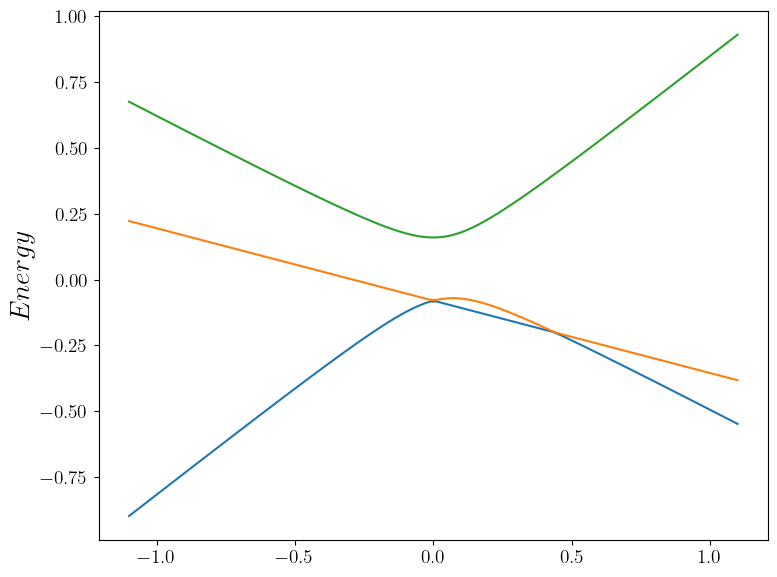

In [323]:
kappa = 1
qy = 0

# U(1), PK, L_mu settings
# delta = 0.25*exp(-1 * im * pi/3) 
# alpha = 1 * exp(2*im * pi/3)
# vF = -2 * real(exp(im * 2 * pi/3) * alpha)

# U(1), PK settings
# delta = 0.25*exp(2 * im * pi/3) 
# alpha = 1 * exp(-2*im * pi/3)
# vF = -2 * real(exp(-im * 2 * pi/3) * alpha)

# C3, PK settings
# delta = 0.08*exp(2 * im * pi/3) 
# alpha = 0.5 * exp(2*im * pi/3)
# vF = -2 * real(exp(-im * 2 * pi/3) * alpha) + 0.55

plain_plotter_energy(kappa, qy, delta, alpha, vF)

In [362]:
function full_plotter_energy(kappa, delta, alpha, vF, spacing)
    qx_list = kappa * range(-1.1, 1.1, 10^2)
    qy = 0
    energies = Array{Float64}(undef, length(qx_list), 3)
    for j in 1:length(qx_list)
        qx = qx_list[j]
        ham = H_k_v2([qx, qy], vF) + H_mft_v2([qx, qy], delta, alpha)
        vals = eigvals(Hermitian(ham))
        energies[j, 1] = vals[1]
        energies[j, 2] = vals[2]
        energies[j, 3] = vals[3]
    end
    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_ylabel(L"$Energy$", fontsize = 20)


    axs.plot(qx_list, energies[:, 1] , label = L"\epsilon_-")
    axs.plot(qx_list, energies[:, 2], label = L"\epsilon_0")
    axs.plot(qx_list, energies[:, 3], label = L"\epsilon_+")

    
    # U(1), L_mu settings
    # delta1 = real(exp(2im*pi/3)*delta) + real(delta)
    # delta3 = 2 * real(exp(-2im*pi/3) * delta)
    # J = vF/2 + real(exp(-2im*pi/3) * alpha)
    # q0 = abs(delta3 - delta1)/abs(J)
    # xticks = [-1, -q0, 0, q0, 1]
    # xlabels = [L"$\gamma$", L"$-q_0$", L"$\kappa$", L"$q_0$",  L"$\kappa '$"]
    # axs.set_xticks(xticks, labels=xlabels)
    # yticks = [delta3, 2*real(delta)]
    # ylabels = [L"$\Delta_3$", L"$\widetilde{\Delta}_1$"]
    # axs.set_yticks(yticks, labels=ylabels)
    # axs.set_ylim(-1, 0.7)

    # U(1) settings
    delta1 = real(exp(2im*pi/3)*delta) + real(delta)
    delta3 = 2 * real(exp(-2im*pi/3) * delta)
    J = vF/2 + real(exp(-2im*pi/3) * alpha)
    q0 = abs(delta3 - delta1)/abs(J)
    xticks = [-1, 0, 1]
    xlabels = [L"$\gamma$", L"$\kappa$",  L"$\kappa '$"]
    axs.set_xticks(xticks, labels=xlabels)
    yticks = [delta3, 2*real(delta)]
    ylabels = [L"$\Delta_3$", L"$\widetilde{\Delta}_1$"]
    axs.set_yticks(yticks, labels=ylabels)
    #axs.set_ylim(-1, 1)

    # inset
    pos = axs.get_position()
    ax_x, ax_y, axw, axh = pos.bounds

    frac_w = 0.3
    frac_h = 0.29

    in_w = axw * frac_w
    in_h = axh * frac_h
    in_x = ax_x + axw - in_w/1.4
    in_y = ax_y + axh - in_h/1.4
    inset_params = [in_x, in_y, in_w, in_h]
    axins = fig.add_axes(inset_params)
    
    # Berry curvature
    n_pts = 10^2
    k_list = range(-1, 1, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)
    bc_list = bc_no_spinors(grid, spacing, vF, delta, alpha, 1)
    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts)) / (pi)

    berry = axins.pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new, cmap="viridis")
    cbar = fig.colorbar(berry, orientation="vertical", location="left")

    # U(1), L_mu ticks
    # cbar.set_ticks([0, 0.5])
    # cbar.set_ticklabels([L"$0$", L"$\pi / 2$"])

    # U(1) ticks
    # cbar.set_ticks([0, 3])
    # cbar.set_ticklabels([L"$0$", L"$3 \pi$"])

    in_ticks = []
    in_labels = []
    axins.set_xticks(in_ticks, labels=in_labels)
    axins.set_yticks(in_ticks, labels=in_labels)

    # Plot hexagons
    hex1 = hex_outline([-1, 0], kappa, 10^(-2))
    hex2 = hex_outline([-1, 0] + [3*kappa/2, kappa*sqrt(3)/2], kappa, 10^(-2))
    hex3 = hex_outline([-1, 0] + [3*kappa/2, -kappa*sqrt(3)/2], kappa, 10^(-2))

    trunc_hex1 = zeros(size(hex1))
    trunc_hex2 = zeros(size(hex2))
    trunc_hex3 = zeros(size(hex3))
    shift = kappa * range(-1, 1, 10^2)
    for j in 1:length(hex1[:, 1])
        if shift[1] <= hex1[j, 1] &&  hex1[j, 1] <= shift[n_pts]
            if shift[1] <= hex1[j, 2] && hex1[j, 2] <= shift[n_pts]
                trunc_hex1[j, : ] = hex1[j, :]
            end
        end
        if shift[1] <= hex2[j, 1] && hex2[j, 1] <= shift[n_pts]
            if shift[1] <= hex2[j, 2] && hex2[j, 2] <= shift[n_pts]
                trunc_hex2[j, : ] = hex2[j, :]
            end
        end
        if shift[1] <= hex3[j, 1] && hex3[j, 1] <= shift[n_pts]
            if shift[1] <= hex3[j, 2] && hex3[j, 2] <= shift[n_pts]
                trunc_hex3[j, : ] = hex3[j, :]
            end
        end
    end
    trunc_hex1 = reshape(trunc_hex1, (:, 2))
    trunc_hex2 = reshape(trunc_hex2, (:, 2))
    trunc_hex3 = reshape(trunc_hex3, (:, 2))

    # U(1), L colors
    # axins.scatter(trunc_hex1[:, 1], trunc_hex1[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")
    # axins.scatter(trunc_hex2[:, 1], trunc_hex2[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")
    # axins.scatter(trunc_hex3[:, 1], trunc_hex3[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")

    # U(1) colors
    axins.scatter(trunc_hex1[:, 1], trunc_hex1[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")
    axins.scatter(trunc_hex2[:, 1], trunc_hex2[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")
    axins.scatter(trunc_hex3[:, 1], trunc_hex3[:, 2], s = 0.3, alpha=0.2, c="salmon", linestyle="-", marker="o")
    
    # U(1), L label
    # axins.text(0.92, 0.92, L"$\Omega(q)$", transform=axins.transAxes, ha="right", va="top", fontsize=13, color="lemonchiffon")

    # U(1) label
    axins.text(0.92, 0.92, L"$\Omega(q)$", transform=axins.transAxes, ha="right", va="top", fontsize=13, color="lemonchiffon")

    fig.tight_layout()

    fig
    # savefig("crit_plots/U(1).png")
end

full_plotter_energy (generic function with 1 method)

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


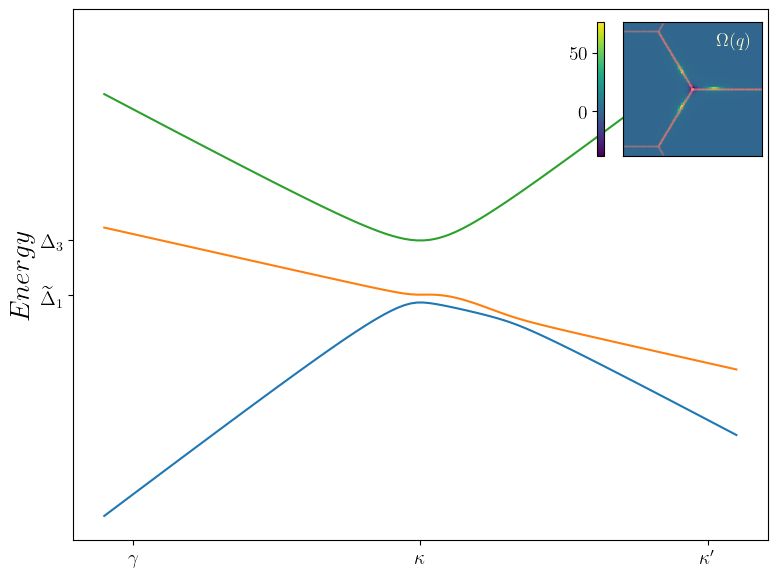

In [384]:
kappa = 1
spacing = 10^(-5)

# U(1), L_mu settings
# delta = 0.25*exp(-1 * im * pi/2)
# alpha = 1.4 * exp(2*im * pi/3)
# vF = -2 * real(exp(im * 2 * pi/3) * alpha)

# U(1) settings
# delta = 0.25*exp(2 * im * pi/3)
# alpha = 1 * exp(2im * pi/3) - 0.5
# vF = -2 * real(exp(-im * 2 * pi/3) * alpha)

delta = 0.08*exp(2 * im * pi/3) + 0.01
alpha = 0.5 * exp(2*im * pi/3)
vF = -2 * real(exp(-im * 2 * pi/3) * alpha) + 0.5


full_plotter_energy(kappa, delta, alpha, vF, spacing)

# Full story figures

In [487]:
function mBZ_plotter(kappa)
    fig, axs = plt.subplots(1,1,figsize=(7, 6))
    gca().set_frame_on(false)

    hex1 = hex_outline([0, 0], kappa, 10^(-3))
    axs.scatter(hex1[:, 1], hex1[:, 2], s = 1.5, alpha=0.9, c="k", linestyle="-", marker="o")
    axs.set_xticks([])
    axs.set_yticks([])

    s = 500
    fsize = 40
    vec_fsize = 40
    # set kappa points
    kappa_list = [L"$\kappa_{1}$", L"$\kappa_{3}$", L"$\kappa_{5}$"]

    for j in 0:2
        x0 = kappa * cos(2*pi/3 * j)
        y0 = kappa * sin(2*pi/3 * j)
        axs.scatter(x0, y0, s = s, alpha=1, c="firebrick", linestyle="-", marker="^")

        axs.text(x0 - 0.22, y0 - 0.03, kappa_list[1 + j], fontsize=fsize, color="firebrick")
    end

    kappa_p_list = [L"$\kappa_{2}$", L"$\kappa_{4}$", L"$\kappa_{6}$"]
    # set kappa' points
    for j in 0:2
        x0 = kappa * cos(pi/3 + 2*pi/3 * j)
        y0 = kappa * sin(pi/3 + 2*pi/3 * j)
        axs.scatter(x0, y0, s = s, alpha=1, c="royalblue", linestyle="-", marker="s")

        axs.text(x0 + 0.075, y0 - 0.03, kappa_p_list[1 + j], fontsize=fsize, color="royalblue")
    end

    # set gamma point
    axs.scatter(0, 0, s = 1000, alpha=1, c="forestgreen", linestyle="-", marker=".")
    axs.text(0 - 0.05, 0.13, L"$\gamma$", fontsize=fsize, color="forestgreen")

    g1_ray = [kappa * cos(0*2*pi/3), kappa*sin(0*2*pi/3)] - [kappa * cos(2*pi/3), kappa*sin(2*pi/3)]
    g1_start = 1 * [kappa * cos(2*pi/3), kappa*sin(2*pi/3)] + 0.08*g1_ray
    g1_delta = 0.75 * g1_ray

    axs.arrow(g1_start[1], g1_start[2], g1_delta[1], g1_delta[2], head_width=0.07, head_length=0.07, linewidth=3,
    linestyle="-", fc="k", ec="k")

    g1_axs_coord = g1_start + 0.5 * g1_delta + [0, -0.19]

    axs.text(g1_axs_coord[1], g1_axs_coord[2], L"$g_1$", fontsize=vec_fsize, color="k")


    g3_ray = [kappa * cos(2*2*pi/3), kappa*sin(2*2*pi/3)] - [kappa * cos(0*2*pi/3), kappa*sin(0*2*pi/3)]
    g3_start = 1 * [kappa * cos(0*2*pi/3), kappa*sin(0*2*pi/3)] + 0.12*g3_ray
    g3_delta = 0.78 * g3_ray

    axs.arrow(g3_start[1], g3_start[2], g3_delta[1], g3_delta[2], head_width=0.07, head_length=0.07, linewidth=3,
    linestyle="-", fc="k", ec="k")


    g3_axs_coord = g3_start + 0.5 * g3_delta + [-0.06, 0.1]

    axs.text(g3_axs_coord[1], g3_axs_coord[2], L"$g_3$", fontsize=vec_fsize, color="k")

    g2_ray = [kappa * cos(1*2*pi/3), kappa*sin(1*2*pi/3)] - [kappa * cos(2*2*pi/3), kappa*sin(2*2*pi/3)]
    g2_start = 1 * [kappa * cos(2*2*pi/3), kappa*sin(2*2*pi/3)] + 0.07*g2_ray
    g2_delta = 0.82 * g2_ray

    axs.arrow(g2_start[1], g2_start[2], g2_delta[1], g2_delta[2], head_width=0.07, head_length=0.07, linewidth=3,
    linestyle="-", fc="k", ec="k")
    
    g2_axs_coord = g2_start + 0.5 * g2_delta + [0.04, 0]

    axs.text(g2_axs_coord[1], g2_axs_coord[2], L"$g_2$", fontsize=vec_fsize, color="k")

    # g3_start = 0.7 * [kappa * cos(0*2*pi/3), kappa*sin(0*2*pi/3)]
    # g3_delta = 0.85 * ([kappa * cos(2*2*pi/3), kappa*sin(2*2*pi/3)] - g3_start)
    # axs.arrow(g3_start[1], g3_start[2], g3_delta[1], g3_delta[2], head_width=0.07, head_length=0.07, linewidth=3,
    # linestyle="-", fc="k", ec="k")

    # g2_start = 0.8 * [kappa * cos(2*2*pi/3), kappa*sin(2*2*pi/3)]
    # g2_delta = 0.85 * ([kappa * cos(1*2*pi/3), kappa*sin(1*2*pi/3)] - g2_start)
    # axs.arrow(g2_start[1], g2_start[2], g2_delta[1], g2_delta[2], head_width=0.07, head_length=0.07, linewidth=3,
    # linestyle="-", fc="k", ec="k")


    fig.tight_layout()

    fig
    # savefig("full_story_figs/mBZ.png")
end

mBZ_plotter (generic function with 1 method)

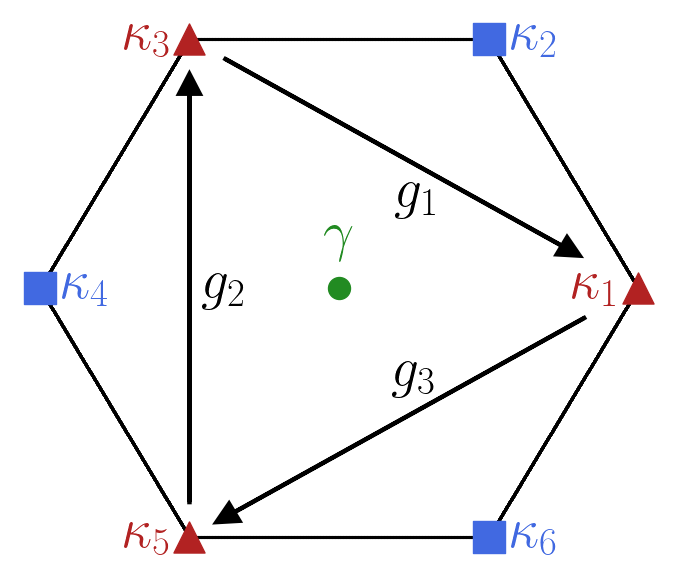

In [488]:
kappa = 1
mBZ_plotter(kappa)

In [45]:
function spinorless_bc_plotting(kappa, delta1, alpha1, vF1, delta2, alpha2, vF2, spacing)
    ion()
    # fac = 0.01
    fac = 0.5
    n_pts = 10^2
    k_list = fac * range(-1, 1, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)
    
    fig, axs = plt.subplots(1,2,figsize=(9, 6))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    # make hexagons
    hex1 = hex_outline([-1, 0], kappa, 10^(-5))
    hex2 = hex_outline([-1, 0] + [3*kappa/2, kappa*sqrt(3)/2], kappa, 10^(-5))
    hex3 = hex_outline([-1, 0] + [3*kappa/2, -kappa*sqrt(3)/2], kappa, 10^(-5))

    trunc_hex1 = zeros(size(hex1))
    trunc_hex2 = zeros(size(hex2))
    trunc_hex3 = zeros(size(hex3))
    shift = fac * kappa * range(-1, 1, 10^2)
    for j in 1:length(hex1[:, 1])
        if shift[1] <= hex1[j, 1] &&  hex1[j, 1] <= shift[n_pts]
            if shift[1] <= hex1[j, 2] && hex1[j, 2] <= shift[n_pts]
                trunc_hex1[j, : ] = hex1[j, :]
            end
        end
        if shift[1] <= hex2[j, 1] && hex2[j, 1] <= shift[n_pts]
            if shift[1] <= hex2[j, 2] && hex2[j, 2] <= shift[n_pts]
                trunc_hex2[j, : ] = hex2[j, :]
            end
        end
        if shift[1] <= hex3[j, 1] && hex3[j, 1] <= shift[n_pts]
            if shift[1] <= hex3[j, 2] && hex3[j, 2] <= shift[n_pts]
                trunc_hex3[j, : ] = hex3[j, :]
            end
        end
    end
    trunc_hex1 = reshape(trunc_hex1, (:, 2))
    trunc_hex2 = reshape(trunc_hex2, (:, 2))
    trunc_hex3 = reshape(trunc_hex3, (:, 2))

    grid_new = reshape(grid, (n_pts, n_pts, 2))

    bc_list1 = bc_no_spinors(grid, spacing, vF1, delta1, alpha1, 1)
    bc_list_new1 = reshape(bc_list1, (n_pts, n_pts)) / (pi)
    bc_list2 = bc_no_spinors(grid, spacing, vF2, delta2, alpha2, 1)
    bc_list_new2 = reshape(bc_list2, (n_pts, n_pts)) / (pi)

    bc_abs1 = maximum(abs.([maximum(bc_list_new1), minimum(bc_list_new1)]))
    bc_abs2 = maximum(abs.([maximum(bc_list_new2), minimum(bc_list_new2)]))

    
    berry1 = axs[1].pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new1, cmap="RdBu", vmin = -bc_abs1, vmax = bc_abs1)
    berry2 = axs[2].pcolormesh(grid_new[:, :, 1], grid_new[:, :, 2], bc_list_new2, cmap="RdBu", vmin = -bc_abs2, vmax = bc_abs2)

    cbar1 = fig.colorbar(berry1, orientation="horizontal", location="top")
    cbar1.set_ticks([-6, 0, 4])
    cbar1.set_ticklabels([L"$- 6 \pi$", L"$0$", L"$4 \pi$"])
    # cbar1.set_ticks([-20000, -10000, -1/5 * 10^4])
    # cbar1.set_ticklabels([L"$- 2 \pi$", L"$- \pi$", L"$- \pi / 5$"])

    

    cbar2 = fig.colorbar(berry2, orientation="horizontal", location = "top")
    cbar2.set_ticks([-10, 0, 5])
    cbar2.set_ticklabels([L"$- 10 \pi$", L"$0$", L"$5 \pi$"])
    # cbar2.set_ticks([-100000, 0, 25000])
    # cbar2.set_ticklabels([L"$-10 \pi$", L"$0$", L"$5 \pi / 2$"])

    # plot hexagons
    alph = 0.02
    s = 0.3
    c = "maroon"
    linestyle = "-"
    marker = "o"
    axs[1].scatter(trunc_hex1[:, 1], trunc_hex1[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[1].scatter(trunc_hex2[:, 1], trunc_hex2[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[1].scatter(trunc_hex3[:, 1], trunc_hex3[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[2].scatter(trunc_hex1[:, 1], trunc_hex1[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[2].scatter(trunc_hex2[:, 1], trunc_hex2[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[2].scatter(trunc_hex3[:, 1], trunc_hex3[:, 2], s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)

    fig.tight_layout()

    fig
    # savefig("full_story_figs/spinorless_n=2.png")
end
    

spinorless_bc_plotting (generic function with 1 method)

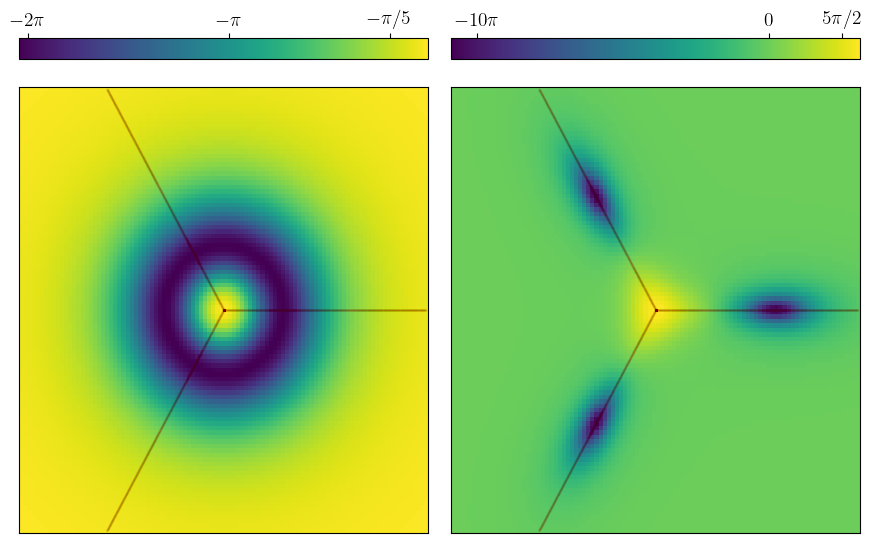

In [665]:
kappa = 1
spacing = 10^(-5)

delta1 = 0.5*exp(2 * im * pi/3) - 0.000003
alpha1 = 0.5 * exp(2*im * pi/3)
vF1 = -2 * real(exp(-im * 2 * pi/3) * alpha1)

delta2 = 0.5*exp(2 * im * pi/3) - 0.000003
alpha2 = 0.5 * exp(2*im * pi/3)
vF2 = -2 * real(exp(-im * 2 * pi/3) * alpha2) + 0.004

spinorless_bc_plotting(kappa, delta1, alpha1, vF1, delta2, alpha2, vF2, spacing)

6.7413402768238

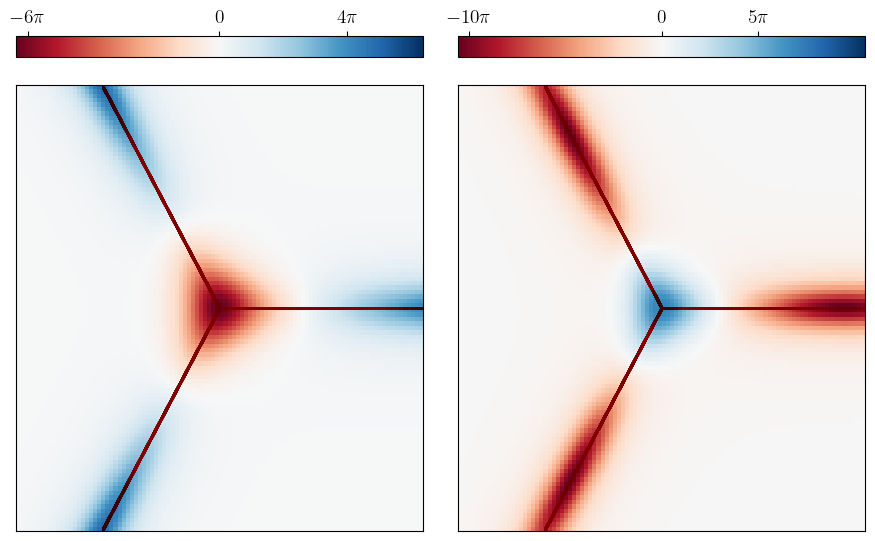

In [47]:
kappa = 1
spacing = 10^(-5)

lambda1 = 0.8
delta1 = lambda_delta(kappa, lambda1, V[1, 1], V[2, 2])/2
alpha1 = lambda_alpha(kappa, lambda1, V[1, 1], V[2, 2])/2
vF1 = 3

lambda2 = 1.2
delta2 = lambda_delta(kappa, lambda2, V[1, 1], V[2, 2])/2
alpha2 = lambda_alpha(kappa, lambda2, V[1, 1], V[2, 2])/2
vF2 = 3


spinorless_bc_plotting(kappa, delta1, alpha1, vF1, delta2, alpha2, vF2, spacing)

In [5]:
function lambda_epsilon_v3(k, n, kappa, gap, vF)
    return (2/n) * vF * sqrt(1 + abs2(gap)) * kappa * sqrt((norm(k)/kappa)^n + abs2(gap))
end
function lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
    kappa = norm(g2)/sqrt(3)
    # connect all lower order mBZ's to their nn
    for i in 1:length(partitions)
        part_i = partitions[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            jdex = dict[part_i .+ part_j]
            if part_j != (0, 0)
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # connect outside ring of mBZ's together
    outer_ring = setdiff(shell_parts, partitions)
    for i in 1:length(outer_ring)
        part_i = outer_ring[i]
        idex = dict[part_i]
        for j in 1:7
            part_j = part_1s[j]
            gi = part_i[1] * g1 + part_i[2] * g2
            gj = gi .+ part_j[1] * g1 + part_j[2] * g2
            if (part_i .+ part_j) in outer_ring && part_j != (0, 0)
                jdex = dict[part_i .+ part_j]
                val = 1/2 * lambda_ff(V, lambda, k .+ gi, k .+ gj)
                ham[idex, jdex] = val
                ham[jdex, idex] = conj(val)
            end
        end
    end
    # add in kinetic terms
    for i in 1:length(shell_parts)
        part = shell_parts[i]
        idex = dict[part]
        gi = part[1] * g1 + part[2] * g2
        ham[idex, idex] = lambda_epsilon_v3(gi .+ k, n, kappa, gap, vF)
    end
    return ham
end
function lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, k, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    for j in 1:num_vertices
        x_new = k[1] + spacing * cos(2 * pi * (j - 1) / num_vertices)
        y_new = k[2] + spacing * sin(2 * pi * (j - 1) / num_vertices)
        ham = lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, [x_new, y_new], lambda, n, gap, vF, V)
        grounds[j, :] = gauge_fix(normalize(eigvecs(Hermitian(ham))[:, index]))
        for m in 1:length(shell_parts)
            momentum = g1 * shell_parts[m][1] + g2 * shell_parts[m][2] + [x_new, y_new]
            spinors[j, m, :] = lambda_spinor(lambda, momentum)
        end
    end
    P = 1
    for j in 1:num_vertices
        if j < num_vertices
            temp = spinor_inner(grounds[j, :], grounds[j + 1, :], spinors[j, :, :], spinors[j + 1, :, :])
            P *= temp / abs(temp)
        else
            temp = spinor_inner(grounds[j, :], grounds[1, :], spinors[j, :, :], spinors[1, :, :])
            P *= temp / abs(temp)
        end
    end
    if abs(imag(P)) < 10^(-16)
        return -(angle(real(P))) / plaq_area
    else
        return -angle(P) / plaq_area
    end
end
function grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    num_vertices = 4

    mBZ_count = num_mBZ(shells)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)

    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    spinors = Array{ComplexF64}(undef, num_vertices, mBZ_count, 2)
    grounds = Array{ComplexF64}(undef, num_vertices, mBZ_count)
    plaq_area = area(spacing * sqrt(2), num_vertices)

    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]

    gi = zeros(2)
    gj = zeros(2)

    berry_list = Array{Float64}(undef, size(grid, 1))

    for i in 1:size(grid, 1)
        berry_list[i] = lambda_mBZ_bc_v3!(g1, g2, num_vertices, plaq_area, shell_parts, partitions, part_1s, dict, ham, spinors, grounds, 
        grid[i, :], lambda, n, gap, vF, kappa, V, shells, index, spacing)
    end
    return berry_list
end
function lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
    mBZ_count = num_mBZ(shells)
    ham = zeros(ComplexF64, mBZ_count, mBZ_count)
    shell_parts = sgn_parts(shells)
    partitions = sgn_parts(shells - 1)
    part_1s = sgn_parts(1)
    dict = part_dict(shells)
    g1 = kappa * sqrt(3) * [-sqrt(3)/2, 1/2]
    g2 = kappa * sqrt(3) * [0, 1]
    lambda_ham_v3!(g1, g2, shell_parts, partitions, part_1s, dict, ham, k, lambda, n, gap, vF, V)
end

lambda_ham_v3 (generic function with 1 method)

In [15]:
function bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    data = Dict("grid" => grid_new, "berry" => bc_list_new, "lambda" => lambda, "n" => n, "vF" => vF, "gap" => gap, "kappa" => kappa, 
    "V" => V, "shells" => shells, "index" => index, "spacing" => spacing)

    @save filename data
end

function gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    v1 = V[1, 1]
    v2 = V[2, 2]
    return "/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/notebooks/lambda_jellium/full_story_figs/n_disp_data/100_data_($lambda, $n, $vF, $v1, $v2).jld2"
end

function bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift_mag, n_pts)
    kx_list = range(kappa - shift_mag, kappa + shift_mag, n_pts)
    ky_list = shift_mag * range(-1, 1, n_pts)
    grid = mesh_grid(kx_list, ky_list, Float64)

    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)

    bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
end

function batch_bc_data_gen(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing, shift_mag, n_pts)
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, shift_mag, n_pts)
            end
        end
    end
end
function bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    
    data = JLD2.load(filename)["data"]

    return data
end

function batch_bc_load_data(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing)
    data_set = []
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
                push!(data_set, data)
            end
        end
    end
    return data_set
end

batch_bc_load_data (generic function with 1 method)

In [20]:
# set the relevant parameters
lambda_list = [0.8, 1.2]
n_list = [4]
vF_list = [3]

kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
bc_spacing = 10^(-2.5)
gap = 10
index = 1
shift_mag = 0.5 * kappa
n_pts = 100

# batch_bc_data_gen(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, bc_spacing, shift_mag, n_pts)

100

In [29]:
function n_disp_bc_plotting(shift_mag, kappa, shells, gap, n, lambda1, V1, vF1, lambda2, V2, vF2, spacing)
    ion()

    fig, axs = plt.subplots(1,2,figsize=(9, 6))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    # make hexagons
    hex1 = hex_outline(kappa * [0, 0], kappa, 10^(-5))
    hex2 = hex_outline(kappa * [0, 0] + [3*kappa/2, kappa*sqrt(3)/2], kappa, 10^(-5))
    hex3 = hex_outline(kappa * [0, 0] + [3*kappa/2, -kappa*sqrt(3)/2], kappa, 10^(-5))

    points_x = []
    points_y = []

    fac = 1

    kx_llm = kappa - fac*shift_mag
    kx_ulm = kappa + fac*shift_mag

    ky_llm = -fac*shift_mag
    ky_ulm = fac*shift_mag

    for j in 1:length(hex1[:, 1])
        if kx_llm <= hex1[j, 1] &&  hex1[j, 1] <= kx_ulm
            if ky_llm <= hex1[j, 2] && hex1[j, 2] <= ky_ulm
                append!(points_x, hex1[j, 1])
                append!(points_y, hex1[j, 2])
            end
        end
        if kx_llm <= hex2[j, 1] && hex2[j, 1] <= kx_ulm
            if ky_llm <= hex2[j, 2] && hex2[j, 2] <= ky_ulm
                append!(points_x, hex2[j, 1])
                append!(points_y, hex2[j, 2])
            end
        end
        if kx_llm <= hex3[j, 1] && hex3[j, 1] <= kx_ulm
            if ky_llm <= hex3[j, 2] && hex3[j, 2] <= ky_ulm
                append!(points_x, hex3[j, 1])
                append!(points_y, hex3[j, 2])
            end
        end
    end

    index = 1

    data1 = bc_load_data(lambda1, n, vF1, gap, kappa, V1, shells, 1, spacing)
    grid1 = data1["grid"]
    bc_list1 = data1["berry"] / (pi)
    bc_abs1 = maximum(abs.([maximum(bc_list1), minimum(bc_list1)]))
    # cut it here to make ring more visible
    # berry1 = axs[1].pcolormesh(grid1[:, :, 1], grid1[:, :, 2], bc_list1, cmap="viridis", vmin = -21000, vmax=5000)
    berry1 = axs[1].pcolormesh(grid1[:, :, 1], grid1[:, :, 2], bc_list1, cmap="RdBu", vmin = -bc_abs1, vmax = bc_abs1)
    cbar1 = fig.colorbar(berry1, orientation="horizontal", location="top")
    cbar1.set_ticks([-6, 0, 2])
    cbar1.set_ticklabels([L"$-6 \pi$", L"$0$", L"$2 \pi$"])
    # cbar1.set_ticks([-20000, 0, 5000])
    # cbar1.set_ticklabels([L"$-2 \pi$", L"$0$", L"$\pi / 2$"])

    data2 = bc_load_data(lambda2, n, vF2, gap, kappa, V2, shells, 1, spacing)
    grid2 = data2["grid"]
    bc_list2 = data2["berry"] / (pi)
    bc_abs2 = maximum(abs.([maximum(bc_list2), minimum(bc_list2)]))
    berry2 = axs[2].pcolormesh(grid2[:, :, 1], grid2[:, :, 2], bc_list2, cmap="RdBu", vmin = -bc_abs2, vmax = bc_abs2)
    cbar2 = fig.colorbar(berry2, orientation="horizontal", location="top")
    cbar2.set_ticks([-30, 0, 10])
    cbar2.set_ticklabels([L"$-30 \pi$", L"$0$", L"$10 \pi$"])
    # cbar2.set_ticks([-30000, 0, 10000])
    # cbar2.set_ticklabels([L"$-3 \pi$", L"$0$", L"$\pi$"])

    # cbar.set_ticks([-1, -2/3, -0.1])
    # cbar.set_ticklabels([L"$- \pi$", L"$-2 \pi / 3$", L"$- \pi / 10$"])

    # plot hexagons
    alph = 0.02
    s = 0.3
    c = "maroon"
    linestyle = "-"
    marker = "o"
    axs[1].scatter(points_x, points_y, s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[2].scatter(points_x, points_y, s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)

    fig.tight_layout()

    fig
    # savefig("full_story_figs/n=2_disp.png")
end
    

n_disp_bc_plotting (generic function with 1 method)

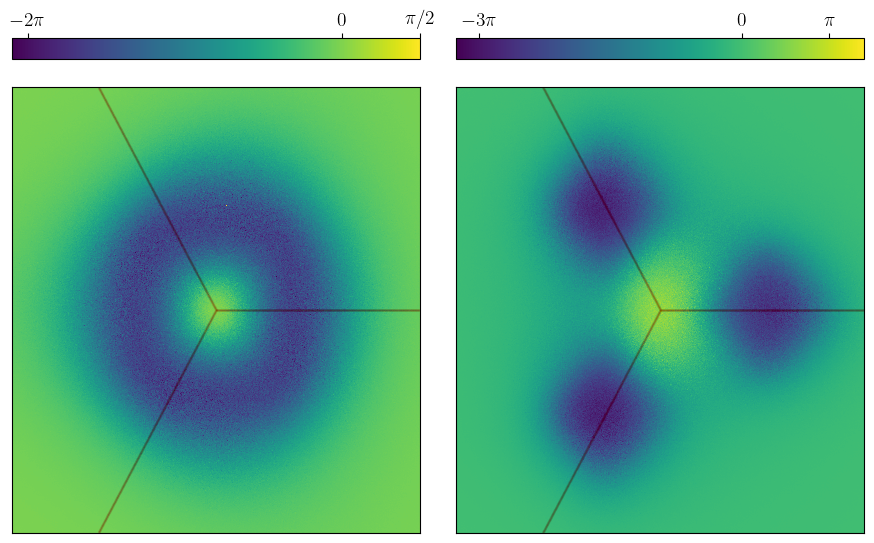

In [8]:
kappa = 1
shells = 5
gap = 10
n = 22
spacing = 10^(-2.5)

lambda1 = 0.9998924 + 0.00003
V1 = [[-1, 0] [0, -1]]
vF1 = 0.7475

lambda2 = 0.9998924 + 0.00003
V2 = [[-1, 0] [0, -1]]
vF2 = 0.7475 - 0.009

shift_mag = 0.01

n_disp_bc_plotting(shift_mag, kappa, shells, gap, n, lambda1, V1, vF1, lambda2, V2, vF2, spacing)

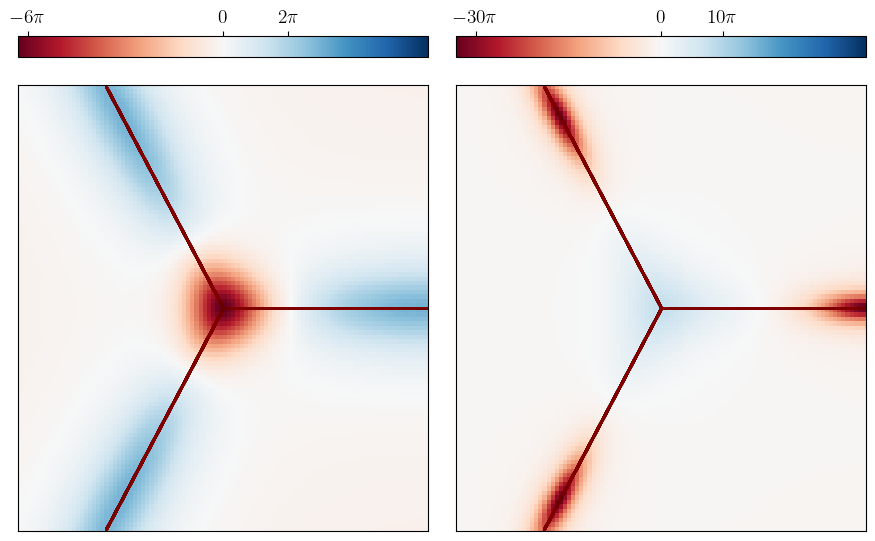

In [30]:
kappa = 1
shells = 5
gap = 10
n = 4
spacing = 10^(-2.5)

lambda1 = 0.8
V1 = [[-1, 0] [0, -1]]
vF1 = 3

lambda2 = 1.2
V2 = [[-1, 0] [0, -1]]
vF2 = 3

shift_mag = 0.5

n_disp_bc_plotting(shift_mag, kappa, shells, gap, n, lambda1, V1, vF1, lambda2, V2, vF2, spacing)

# $C_2$ angular momentum change

In [8]:
function tol_ang(z::Complex; tol=1e-8)
    theta = angle(z) 
    if abs(abs(theta) - pi) < tol
        return pi
    else
        return theta
    end
end
function C2_ev(n, gap, lambda, vF, kappa, V, shells)
    q1 = kappa * [-3/4, sqrt(3)/4]
    parts = part_dict(shells)
    rel_indices = [parts[(1, 0)], parts[(-1, 0)]]

    ham1 = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
    vec1 = gauge_fix(normalize(eigvecs(ham1)[:, 1]))
    vector = vec1[rel_indices]

    return round(tol_ang(vector[1]/vector[2])/pi)
end
function plot_C2_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        gaps[i] = C2_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\ell_{2}$")
    axs.set_title(L"$\ell_2 \text{ vs } v_F$")
    axs.plot(vF_list, gaps)
    fig
end
function plot_C2_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        gaps[i] = C2_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\ell_{2}$")
    axs.set_title(L"$\ell_2 \text{ vs } \lambda$")
    axs.plot(lambda_list, gaps)
    fig
end
function C3_ev(n, gap, lambda, vF, kappa, V, shells)
    parts = part_dict(shells)

    q1 = kappa * [cos(2*pi/3), sin(2*pi/3)]
    rel_indices = [parts[(1, -1)], parts[(-1, 1)]]
    ham1 = lambda_ham_v3(q1, lambda, n, gap, vF, kappa, V, shells)
    vec1 = gauge_fix(normalize(eigvecs(ham1)[:, 1]))
    vector = vec1[rel_indices]

    ang_kap = round(tol_ang(vector[1]/vector[2])/(2*pi/3))

    q2 = kappa * [0, 0]
    rel_indices = [parts[(1, -1)], parts[(-1, 1)]]
    ham2 = lambda_ham_v3(q2, lambda, n, gap, vF, kappa, V, shells)
    vec2 = gauge_fix(normalize(eigvecs(ham2)[:, 1]))
    vector = vec2[rel_indices]

    ang_og = round(tol_ang(vector[1]/vector[2])/(2*pi/3))

    return ang_kap + ang_og
end
function plot_C3_phase_vF(n, gap, lambda, kappa, V, shells, llm, ulm)
    vF_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(vF_list))
    for i in 1:length(vF_list)
        vF = vF_list[i]
        gaps[i] = C3_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$v_F$")
    axs.set_ylabel(L"$\ell_{3}$")
    axs.set_title(L"$\ell_3 \text{ vs } v_F$")
    axs.plot(vF_list, gaps)
    fig
end
function plot_C3_phase_lambda(n, gap, vF, kappa, V, shells, llm, ulm)
    lambda_list = range(llm, ulm, 10^2)
    gaps = Array{Float64}(undef, length(lambda_list))
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        gaps[i] = C3_ev(n, gap, lambda, vF, kappa, V, shells)
    end
    fig, axs = plt.subplots(1,1,figsize=(15, 8))
    axs.set_xlabel(L"$\lambda$")
    axs.set_ylabel(L"$\ell_{3}$")
    axs.set_title(L"$\ell_3 \text{ vs } \lambda$")
    axs.plot(lambda_list, gaps)
    fig
end
function chern_mod_6(c2, c3)
    if c2 == 0
        if c3 == -1
            return 2
        elseif c3 == 0
            return 0
        elseif c3 == 1
            return 4
        end
    elseif c2 == 1
        if c3 == -1
            return 5
        elseif c3 == 0
            return 3
        elseif c3 == 1
            return 1
        end
    end
end

chern_mod_6 (generic function with 1 method)

In [9]:
function bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
    bc_list = grid_bc_v3(grid, lambda, n, gap, vF, kappa, V, shells, index, spacing)
    grid_new = reshape(grid, (n_pts, n_pts, 2))
    bc_list_new = reshape(bc_list, (n_pts, n_pts))

    data = Dict("grid" => grid_new, "berry" => bc_list_new, "lambda" => lambda, "n" => n, "vF" => vF, "gap" => gap, "kappa" => kappa, 
    "V" => V, "shells" => shells, "index" => index, "spacing" => spacing)

    @save filename data
end

function gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    v1 = V[1, 1]
    v2 = V[2, 2]
    return "/Users/avadali/Desktop/Desktop - Avi's Mac/Summer2024/AHC_code/notebooks/lambda_jellium/n_disp_bc_data/data_($lambda, $n, $vF, $v1, $v2).jld2"
end

function bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale, n_pts)
    k_list = scale * range(-kappa, kappa, n_pts)
    grid = mesh_grid(k_list, k_list, Float64)

    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)

    bc_save_data_n_disp(lambda, n, vF, gap, kappa, V, shells, index, spacing, n_pts, grid, filename)
end

function batch_bc_data_gen(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing, scale, n_pts)
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                bc_data_gen(lambda, n, vF, gap, kappa, V, shells, index, spacing, scale, n_pts)
            end
        end
    end
end

function bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    filename = gen_file_name(lambda, n, vF, gap, kappa, V, shells, index, spacing)
    
    data = JLD2.load(filename)["data"]

    return data
end

function batch_bc_load_data(lambda_list, n_list, vF_list, gap, kappa, V, shells, index, spacing)
    data_set = []
    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(n_list)
            n = n_list[j]
            for k in 1:length(vF_list)
                vF = vF_list[k]
                data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
                push!(data_set, data)
            end
        end
    end
    return data_set
end

function batch_bc_plot_cb1_chern(lambda_list, n, vF_list, gap, kappa, V, shells, index, spacing)
    n0 = Int(n/2)
    xdim = 8 * length(vF_list)
    ydim = 9 * length(lambda_list)
    fig, axs = plt.subplots(length(lambda_list), length(vF_list),figsize=(xdim, ydim))

    for i in 1:length(lambda_list)
        lambda = lambda_list[i]
        for j in 1:length(vF_list)
            vF = vF_list[j]
            data = bc_load_data(lambda, n, vF, gap, kappa, V, shells, index, spacing)
            grid = data["grid"]
            berry = data["berry"]

            chern_2 = C2_ev(n, gap, lambda, vF, kappa, V, shells)
            chern_3 = C3_ev(n, gap, lambda, vF, kappa, V, shells)

            chern = chern_mod_6(chern_2, chern_3)

            bc_min = minimum(berry)
            bc_max = maximum(berry)
            bc_abs = maximum(abs.([bc_min, bc_max]))

            axs[i, j].set_xlabel(L"q_x", fontsize=16)
            axs[i, j].set_ylabel(L"q_y", fontsize=16)
            axs[i, j].set_title("\$(\\lambda, v_F, n, C) = ($(lambda), $(vF), $(n0), $(chern)) \$", fontsize=16, pad=8)

            bc_plot = axs[i, j].pcolormesh(grid[:, :, 1], grid[:, :, 2], berry, cmap="RdBu", vmin = -bc_abs, vmax = bc_abs)

            cbar = fig.colorbar(bc_plot, orientation="horizontal", location="top", ax=axs[i, j])

        end
    end

    fig.tight_layout()
    fig
end

batch_bc_plot_cb1_chern (generic function with 1 method)

In [10]:
function plot_C2_change(lambda1, lambda2, n, vF1, vF2, gap, kappa, V, shells, index, spacing)
    data1 = bc_load_data(lambda1, n, vF1, gap, kappa, V, shells, index, spacing)
    grid1 = data1["grid"]
    bc1 = data1["berry"] / (pi)
    bc_min1 = minimum(bc1)
    bc_max1 = maximum(bc1)
    bc_abs1 = maximum(abs.([bc_min1, bc_max1]))
    
    data2 = bc_load_data(lambda2, n, vF2, gap, kappa, V, shells, index, spacing)
    grid2 = data2["grid"]
    bc2 = data2["berry"] / (pi)
    bc_min2 = minimum(bc2)
    bc_max2 = maximum(bc2)
    bc_abs2 = maximum(abs.([bc_min2, bc_max2]))

    ion()
    fig, axs = plt.subplots(1,2,figsize=(9, 6))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    berry1 = axs[1].pcolormesh(grid1[:, :, 1], grid1[:, :, 2], bc1, cmap="RdBu", vmin = -bc_abs1, vmax = bc_abs1)
    cbar1 = fig.colorbar(berry1, orientation="horizontal", location="top")
    cbar1.set_ticks([-20, 0, 20])
    cbar1.set_ticklabels([L"$-20 \pi$", L"$0$", L"$20 \pi$"])

    berry2 = axs[2].pcolormesh(grid2[:, :, 1], grid2[:, :, 2], bc2, cmap="RdBu", vmin = -bc_abs2, vmax = bc_abs2)
    cbar2 = fig.colorbar(berry2, orientation="horizontal", location="top")
    cbar2.set_ticks([-5, 0, 5])
    cbar2.set_ticklabels([L"$-5 \pi$", L"$0$", L"$5 \pi$"])

    # make hexagons
    points_x = []
    points_y = []

    k_llm = -1.5
    k_ulm = 1.5

    hex0 = hex_outline([0, 0], kappa, 10^(-5))
    for j in 1:length(hex0[:, 1])
        if k_llm <= hex0[j, 1] && hex0[j, 1] <= k_ulm
            if k_llm <= hex0[j, 2] && hex0[j, 2] <= k_ulm
                append!(points_x, hex0[j, 1])
                append!(points_y, hex0[j, 2])
            end
        end
    end

    for i in 1:6
        x0 = cos(pi/6 + pi/3 * i)
        y0 = sin(pi/6 + pi/3 * i)
        hex = hex_outline([0, 0] + sqrt(3) * kappa * [x0, y0], kappa, 10^(-5))
        for j in 1:length(hex[:, 1])
            if k_llm <= hex[j, 1] && hex[j, 1] <= k_ulm
                if k_llm <= hex[j, 2] && hex[j, 2] <= k_ulm
                    append!(points_x, hex[j, 1])
                    append!(points_y, hex[j, 2])
                end
            end
        end
    end

    # plot hexagons
    alph = 0.0025
    s = 0.3
    c = "maroon"
    linestyle = "-"
    marker = "o"
    axs[1].scatter(points_x, points_y, s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)
    axs[2].scatter(points_x, points_y, s = s, alpha=alph, c=c, linestyle=linestyle, marker=marker)

    fig.tight_layout()

    
    # savefig("C2_ang/n=11_comp.png")
    fig
end

plot_C2_change (generic function with 1 method)

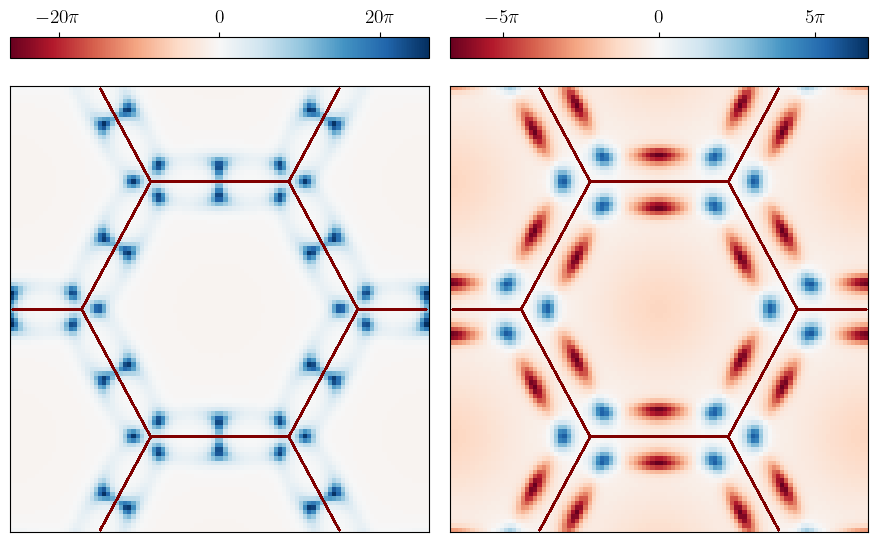

In [11]:
lambda1 = 1.1
lambda2 = 1.5
n = 22
vF1 = 1.5
vF2 = 1.5
gap = 10
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
index = 1
bc_spacing = 10^(-2.5)
plot_C2_change(lambda1, lambda2, n, vF1, vF2, gap, kappa, V, shells, index, bc_spacing)

# Berry curvature catalogs

# Band structure figures

In [159]:
function plot_bands_n_disp(lambda, n, gap, vF, kappa, V, shells, ky, llm, ulm)
    n_pts = 10^3

    kx_list = range(llm, ulm, n_pts)

    energies = Array{Float64}(undef, n_pts, 3)

    for j in 1:(n_pts)
        k = [kx_list[j], ky]
        ham = lambda_ham_v3(k, lambda, n, gap, vF, kappa, V, shells)
        vals = eigvals(Hermitian(ham))
        energies[j, 1] = vals[1]
        energies[j, 2] = vals[2]
        energies[j, 3] = vals[3]
    end
    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))
    axs.set_ylabel(L"$Energy$", fontsize = 20)

    axs.plot(kx_list, energies[:, 1], label = L"\epsilon_-")
    axs.plot(kx_list, energies[:, 2], label = L"\epsilon_0")
    # axs.plot(kx_list, energies[:, 3], label = L"\epsilon_+")

    xticks = [0.95, 1, 1.05]
    xlabels = [L"$\kappa_1 - \delta$", L"$\kappa_1$", L"$\kappa_1 + \delta$"]
    axs.set_xticks(xticks, labels=xlabels)

    # yticks = [minimum(energies[:, 1]), minimum(energies[:, 3])]
    # ylabels = [L"$min(\epsilon_-)$", L"$min(\epsilon_+)$"]

    yticks = [minimum(energies[:, 2]), maximum(energies[:, 1]), maximum(energies[:, 2])]
    ylabels = [L"$min(\epsilon_0)$", L"$max(\epsilon_-)$", L"$max(\epsilon_0)$"]

    axs.set_yticks(yticks, labels=ylabels)
    # axs.set_yticks([])
    fig.tight_layout()

    print((maximum(energies[:, 1]) - minimum(energies[:, 1])) / (minimum(energies[:, 3] - energies[:, 1])))

    # savefig("n_disp_bands/dirac_point.png")
    
    fig
end

plot_bands_n_disp (generic function with 2 methods)

0.009452085839982426

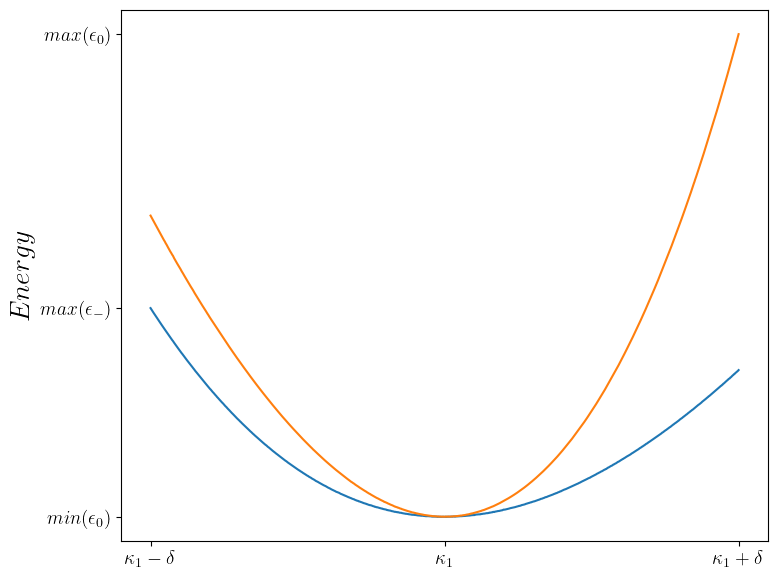

In [160]:
# set the relevant parameters
lambda = 0.9998924
n = 22
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
ky = 0
llm = 0.95
ulm = 1.05
gap = 10

vF = 0.7475

plot_bands_n_disp(lambda, n, gap, vF, kappa, V, shells, ky, llm, ulm)

# Comparison between $n = 2$ and spinorless

In [238]:
function angular_bc_plots(bc_spacing, lambda, vF, gap, index, kappa, V, shells, k_mag)
    n_pts = 10^3
    angs = range(-pi, pi, n_pts)
    berry_list = Array{Float64}(undef, n_pts, 2)

    kappa_1 = kappa * [1, 0]
    
    for j in 1:n_pts
        mom = k_mag * [cos(angs[j]), sin(angs[j])]
        mBZ_mom = kappa_1 .+ mom

        berry_list[j, 1] = grid_bc_v3(reshape(mBZ_mom, (1, 2)), lambda, n, gap, vF, kappa, V, shells, index, bc_spacing)[1]

        v1 = V[1, 1]
        v2 = V[2, 2]
        delta = 1/2 * lambda_delta(kappa, lambda, v1, v2)
        alpha = 1/2 * lambda_alpha(kappa, lambda, v1, v2)
        berry_list[j, 2] = lambda_patch_bc(reshape(mom, (1, 2)), bc_spacing, lambda, kappa, vF, delta, alpha, 1)[1]
    end

    ion()
    fig, axs = plt.subplots(1,1,figsize=(8, 6))


    axs.plot(angs/pi, berry_list[:, 1]/pi, label = L"$\Omega^{quad}$")
    axs.plot(angs/pi, berry_list[:, 2]/pi, label = L"$\Omega^{tot}$")

    axs.set_xlabel(L"$\arg(q)$", fontsize=20)
    axs.set_ylabel(L"$\Omega$", fontsize=20)
    xticks = [-2/3, 0, 2/3]
    xlabels = [L"-2 \pi /3", L"0", L"2 \pi / 3"]
    axs.set_xticks(xticks, labels=xlabels)
    axs.set_yticks([])

    axs.legend()

    fig.tight_layout()

    fig
    # savefig("n=2_comp_figs/lambda=1.2_vF=100.png")
end

angular_bc_plots (generic function with 2 methods)

In [237]:
# set the relevant parameters
bc_spacing = 10^(-3)
lambda = 1.2
vF = 100
n = 4
kappa = 1
V = [[-1, 0] [0, -1]]
shells = 5
gap = 10
index = 1
k_mag = 0.1 * kappa

angular_bc_plots(bc_spacing, lambda, vF, gap, index, kappa, V, shells, k_mag)
